# 3. Make predictions for the year 2024

In [60]:
# Load necessary packages
import lightgbm as lgb
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import yaml
import os
from datetime import datetime
import sys
from sklearn.model_selection import train_test_split
import sklearn.metrics
import pickle

import optuna

import multiprocessing as mp
from multiprocessing import Pool
# import s3fs
from datetime import datetime

with open("./_config.yaml", "r") as file:
    cherry_config = yaml.safe_load(file)
comp_data_dir = cherry_config['competition_data']
data_dir = cherry_config['data_dir']     # data generated from A__dataPrep.ipynb
model_dir = cherry_config['model_dir']   # output dir for the best trained lgb models

In [61]:
# Define functions for computing Ca_cumsum and Cd_cumsum

def compute_gdd(r):
    gdd = (r[['tmax']].item() + r[['tmin']].item())/2
    return gdd if gdd > 0 else 0


def chill_days(r, Tc):
    '''
    Following Cesaraccio
    '''
    Tmin = r[['tmin']].item()
    Tmax = r[['tmax']].item()
    Tmean = (Tmin + Tmax)/2

    if (0 <= Tc) & (Tc <= Tmin) & (Tmin <= Tmax):
        Cd = 0
        Ca = Tmean - Tc

    elif (0 <= Tmin) & (Tmin <= Tc) & (Tc <= Tmax):
        Cd = -1 * ((Tmean - Tmin) - ((Tmax - Tc)/2))
        Ca = (Tmax - Tc)/2
    
    elif (0 <= Tmin) & (Tmin <= Tmax) & (Tmax <= Tc):
        Cd = -1 * (Tmean - Tmin)
        Ca = 0
    
    elif (Tmin <= 0) & (0 <= Tmax) & (Tmax <= Tc):
        Cd = -1 * (Tmax / (Tmax - Tmin)) * (Tmax/2)
        Ca = 0
    
    elif (Tmin <= 0) & (0 <= Tc) & (Tc <= Tmax):
        Cd = -1 * ((Tmax / (Tmax - Tmin)) * (Tmax/2) - ((Tmax - Tc)/2))
        Ca = (Tmax - Tc) / 2
    
    elif (Tmax < 0):
        Cd = 0
        Ca = 0
    
    else:
        Cd = 0
        Ca = 0

    # r['Cd'] = Cd
    # r['Ca'] = Ca

    return Cd, Ca

def compute_cgdd(station_df, station_id, Rc_thresh, Tc):

    # Computes daily_Ca, daily_Cd, Ca_cumsum, Cd_cumsum.
    # weather_df should have at least: tmax, tmin
    
    # Rc_thresh and Tc are learnt from gdd_model
    # Rc_thresh accumulated Cd threshold to start accumulating GDD.
    # Tc: Threshold temperature for computing Ca and Cd.

    output_list = {}
    
    Ca_Cd_df = station_df.copy()
    
    Ca_Cd_df['date'] = Ca_Cd_df.apply(lambda x : "-".join([str(x["year"]), str(x["month"]), str(x["day"])]), axis = 1)
    Ca_Cd_df['date'] = pd.to_datetime(Ca_Cd_df['date'])
    
    Ca_Cd_df['daily_Cd'], Ca_Cd_df['daily_Ca'] = zip(*Ca_Cd_df.apply(lambda row: chill_days(row, Tc = Tc), axis = 1))
    
    ## Compute Ca_cumsum (a.k.a AGDD) and Cd_cumsum
    years = Ca_Cd_df['year'].unique()
    # years = [1992, 1993, 1994]
    for yr in years:
        # yr = years[1]
        # print(yr)
        Rc_start = datetime.strptime(str(int(yr) - 1) + "-09-30", "%Y-%m-%d")
        
        sub_df = Ca_Cd_df.loc[(Rc_start < Ca_Cd_df["date"]) & (Ca_Cd_df["date"] < datetime.strptime(str(yr)+"-06-01", "%Y-%m-%d")), :].reset_index(drop = True)
    
        list_id = station_id + "-" + str(yr)

        if len(sub_df['month'].unique()) != 8:
            # print("next")
            continue            

        sub_df['Cd_cumsum'] = sub_df['daily_Cd'].cumsum()

        if (np.isin("prcp", sub_df.columns)):
            sub_df["prcp_cumsum"] = sub_df["prcp"].cumsum()
        
        sub_df['Ca_cumsum'] = 0

        if sub_df[sub_df['Cd_cumsum'] < Rc_thresh].shape[0] == 0:
            continue
        
        Rc_thresh_loc = sub_df[sub_df['Cd_cumsum'] < Rc_thresh].index[0]

        if pd.isna(Rc_thresh_loc):
            Rc_thresh_loc = sub_df[sub_df['Cd_cumsum'] < Rc_thresh].index[0]
            if pd.isna(Rc_thresh_loc):
                continue

        Rc_thresh_day = sub_df.iloc[Rc_thresh_loc]['date']
        # print(paste0("reaches the Rc threshold on ", Rc_thresh_day)) # 저온요구도 달성일 i.e., 내생휴면 해제일. 

        if int(Rc_thresh_day.timetuple().tm_yday) > 31:
            first_Tc_reach_day = datetime.strptime(str(yr) + "-01-31", "%Y-%m-%d")
        else:
            sub_df_afterRc = sub_df.iloc[range(Rc_thresh_loc, sub_df.shape[0]), :].reset_index(drop = True)
            first_Tc_reach_loc = sub_df_afterRc[sub_df_afterRc['tmax'] > Tc].index[0]
            first_Tc_reach_day = sub_df_afterRc.iloc[first_Tc_reach_loc]['date']

        if pd.isna(first_Tc_reach_day):
            # print("is na first tc reach day")
            continue
        
        first_Tc_reach_loc2 = sub_df[sub_df["date"] == first_Tc_reach_day].index[0] # Ca accumulates starting this day.
        sub_df.loc[first_Tc_reach_loc2:sub_df.shape[0], "Ca_cumsum"] = sub_df.loc[first_Tc_reach_loc2:sub_df.shape[0], "daily_Ca"].cumsum()
        
        # sub_df["diff_Ca_Cd"] = sub_df['daily_Ca'].abs() - sub_df['daily_Cd'].abs()
        # sub_df["diff_Ca_Cd_cumsum"] = sub_df['diff_Ca_Cd'].cumsum()
        
        sub_df = sub_df[sub_df['month'].isin([1,2,3,4,5])].reset_index(drop=True)

        sub_df['daily_gdd'] = sub_df.apply(lambda row: compute_gdd(row), axis = 1)
        sub_df['AGDD'] = sub_df['daily_gdd'].cumsum()
        
        output_list[list_id] = sub_df

    if len(output_list) == 0:
        return pd.DataFrame(columns = sub_df.columns)
    elif len(output_list) == 1:
        out_df = output_list[list(output_list.keys())[0]].dropna().reset_index(drop = True)
    elif len(output_list) > 1:
        out_df = pd.concat(output_list, axis = 0).dropna().reset_index(drop = True)
    

    # return(out_df)
    
    return out_df


def generate_cgdds(temperature_df, st, Tc, Rc_thresh):
    
    # st = target_ids[3]
    station_temp = temperature_df[temperature_df["id"] == st]
    city_name = station_temp.iloc[1]["city"]
    # city_name
    station_bloom_years = station_temp['year'].unique()
     
    sub_cds = compute_cgdd(station_df = station_temp, station_id = st, Rc_thresh = Rc_thresh, Tc=Tc)
    
    return sub_cds


def generate_data(temperature_df, target_ids, Tc, Rc_thresh, pooling = False):
    
    args = [(temperature_df, id, Tc, Rc_thresh) for id in target_ids]
        
    if pooling == True:
        n_cpus = 7
        pool = Pool(processes = n_cpus)
        
        df = pd.concat(pool.starmap(generate_cgdds, args), axis = 0)
        pool.close()
        pool.join()
    else:
        df = pd.concat([generate_cgdds(*arg) for arg in args], axis = 0)

    return df

## 3a. Load trained models

In [62]:
# Load models
with open(model_dir + "/B11_lgb_kyoto.pkl" ,"rb") as m1:
    lgb_kyoto = pickle.load(m1)

with open(model_dir + "/B21_lgb_liestal.pkl", "rb") as m2:
    lgb_liestal = pickle.load(m2)

with open(model_dir + "/B31_lgb_america.pkl", "rb") as m3:
    lgb_ame = pickle.load(m3)

## 3b. Load temperature data

* Temperature forecasts acquired from AccuWeather

In [63]:
# Kyoto
kyoto_blooms = pd.read_csv(comp_data_dir + "/kyoto.csv")
kyoto_lat = kyoto_blooms.iloc[0]["lat"]
kyoto_long = kyoto_blooms.iloc[0]["long"]
kyoto_alt = kyoto_blooms.iloc[0]["alt"]

kyoto_temps = pd.read_csv(data_dir + "/C11_kyoto_temp_2224.csv")   # Acquired from AccuWeather
kyoto_temps = kyoto_temps.query('year >= 2023')
kyoto_temps['city'] = "Kyoto"

kyoto_df = generate_data(kyoto_temps, target_ids = ["JA000047759"], Tc = 7, Rc_thresh = -100)
kyoto_df['lat'] = kyoto_lat
kyoto_df['long'] = kyoto_long
kyoto_df['alt'] = kyoto_alt
kyoto_df = kyoto_df.query("year == 2024")
kyoto_df = kyoto_df.loc[(2 < kyoto_df['month']) , :]

cgdd_predictors = ["lat", "long", "alt", "Ca_cumsum", "Cd_cumsum", "AGDD", "month"]
kyoto_newX = kyoto_df[cgdd_predictors]

In [64]:
# Liestal
liestal_blooms = pd.read_csv(comp_data_dir + "/liestal.csv")
liestal_lat = liestal_blooms.iloc[0]["lat"]
liestal_long = liestal_blooms.iloc[0]["long"]
liestal_alt = liestal_blooms.iloc[0]["alt"]

liestal_temps = pd.read_csv(data_dir + "/C21_liestal_temp_2224.csv")   # Acquired from AccuWeather
liestal_temps = liestal_temps.query('year >= 2023')
liestal_temps['city'] = "Liestal"

liestal_df = generate_data(liestal_temps, target_ids = ["GME00127786"], Tc = 7, Rc_thresh = -100)
liestal_df['lat'] = liestal_lat
liestal_df['long'] = liestal_long
liestal_df['alt'] = liestal_alt

liestal_df = liestal_df.query("year == 2024")
liestal_df = liestal_df.loc[(2 < liestal_df['month']), :]

liestal_newX = liestal_df[cgdd_predictors]

In [65]:
dc_blooms = pd.read_csv(comp_data_dir + "/washingtondc.csv")
dc_lat = dc_blooms.iloc[0]["lat"]
dc_long = dc_blooms.iloc[0]["long"]
dc_alt = dc_blooms.iloc[0]["alt"]

dc_temps = pd.read_csv(data_dir + "/C31_washingtondc_temp_2224.csv")   # Acquired from AccuWeather
dc_temps = dc_temps.query('year >= 2023')
dc_temps['city'] = "DC"

dc_df = generate_data(dc_temps, target_ids = ["USC00186350"], Tc = 7, Rc_thresh = -100)
dc_df['date'] = pd.to_datetime(dc_df['date'])
dc_df["Day_of_Year"] = dc_df.loc[:, "date"].apply(lambda row: pd.Period(row, freq = "D").day_of_year)
dc_df['Latitude'] = dc_lat
dc_df['Longitude'] = dc_long
dc_df['Elevation_in_Meters'] = dc_alt
dc_df['State'] = 'DC'
dc_df['State'] = dc_df['State'].astype('category')
dc_df["Species"] = "yedoensis"
dc_df = dc_df.query("year == 2024")

npn_predictors = ["Longitude","Latitude","Elevation_in_Meters","State","Day_of_Year","AGDD"]

dc_newX = dc_df[npn_predictors]

In [66]:
ny_blooms = pd.read_csv(data_dir + "/A31_america_temperatures2.csv").query("State == 'NY'")
ny_lat = ny_blooms.iloc[0]["Latitude"]
ny_long = ny_blooms.iloc[0]["Longitude"]
ny_alt = ny_blooms.iloc[0]["Elevation_in_Meters"]

ny_temps = pd.read_csv(data_dir + "/C31_newyorkcity_temp_2224.csv")   # Acquired from AccuWeather
ny_temps = ny_temps.query('year >= 2023')
ny_temps['city'] = "NY"

ny_df = generate_data(ny_temps, target_ids = ["USW00094728"], Tc = 7, Rc_thresh = -100)
ny_df['date'] = pd.to_datetime(ny_df['date'])
ny_df["Day_of_Year"] = ny_df.loc[:, "date"].apply(lambda row: pd.Period(row, freq = "D").day_of_year)
ny_df['Latitude'] = ny_lat
ny_df['Longitude'] = ny_long
ny_df['Elevation_in_Meters'] = ny_alt
ny_df['State'] = 'ny'
ny_df['State'] = ny_df['State'].astype('category')
ny_df["Species"] = "yedoensis"
ny_df = ny_df.query("year == 2024")

npn_predictors = ["Longitude","Latitude","Elevation_in_Meters","State","Day_of_Year","AGDD"]

ny_newX = ny_df[npn_predictors]

In [67]:
bc_blooms = pd.read_csv(data_dir + "/A31_america_temperatures2.csv").query("State == 'BC'")
bc_lat = bc_blooms.iloc[0]["Latitude"]
bc_long = bc_blooms.iloc[0]["Longitude"]
bc_alt = bc_blooms.iloc[0]["Elevation_in_Meters"]

bc_temps = pd.read_csv(data_dir + "/C31_vancouver_temp_2224.csv")   # Acquired from AccuWeather
bc_temps = bc_temps.query('year >= 2023')
bc_temps['city'] = "bc"

bc_df = generate_data(bc_temps, target_ids = ["CA001108395"], Tc = 7, Rc_thresh = -100)
bc_df['date'] = pd.to_datetime(bc_df['date'])
bc_df["Day_of_Year"] = bc_df.loc[:, "date"].apply(lambda row: pd.Period(row, freq = "D").day_of_year)
bc_df['Latitude'] = bc_lat
bc_df['Longitude'] = bc_long
bc_df['Elevation_in_Meters'] = bc_alt
bc_df['State'] = 'bc'
bc_df['State'] = bc_df['State'].astype('category')
bc_df["Species"] = "yedoensis"
bc_df = bc_df.query("year == 2024")

npn_predictors = ["Longitude","Latitude","Elevation_in_Meters","State","Day_of_Year","AGDD"]

bc_newX = bc_df[npn_predictors]

## 3d. Make final predictions for the year 2024

In [68]:
pred_kyoto = lgb_kyoto.predict(kyoto_newX)
pred_kyoto_idx = np.where(pred_kyoto == np.max(pred_kyoto))[0][0]
pred_kyoto_date = kyoto_df.iloc[pred_kyoto_idx]['date']
pred_kyoto_doy = pd.Period(pred_kyoto_date, freq = "D").day_of_year
print(pred_kyoto_date)
print(pred_kyoto_doy)

2024-05-01 00:00:00
122


In [69]:
pred_liestal = lgb_liestal.predict(liestal_newX)
pred_liestal_idx = np.where(pred_liestal == np.max(pred_liestal))[0][0]
pred_liestal_date = liestal_df.iloc[pred_liestal_idx]['date']
pred_liestal_doy = pd.Period(pred_liestal_date, freq = "D").day_of_year
print(pred_liestal_date)
print(pred_liestal_doy)

2024-04-01 00:00:00
92


In [70]:
# Make prediction for washingtondc
pred_dc = lgb_ame.predict(dc_newX)
pred_dc_idx = np.where(pred_dc == np.max(pred_dc))[0][0]
pred_dc_date = dc_df.iloc[pred_dc_idx]['date']
pred_dc_doy = pd.Period(pred_dc_date, freq = "D").day_of_year
print(pred_dc_date)
print(pred_dc_doy)

2024-03-20 00:00:00
80


In [71]:
# Make prediction for New York City
pred_ny = lgb_ame.predict(ny_newX)
pred_ny_idx = np.where(pred_ny == np.max(pred_ny))[0][0]
pred_ny_date = ny_df.iloc[pred_ny_idx]['date']
pred_ny_doy = pd.Period(pred_ny_date, freq = "D").day_of_year
print(pred_ny_date)
print(pred_ny_doy)

2024-04-09 00:00:00
100


In [72]:
# Make prediction for Vancouver
pred_bc = lgb_ame.predict(bc_newX)
pred_bc_idx = np.where(pred_bc == np.max(pred_bc))[0][0]
pred_bc_date = bc_df.iloc[pred_bc_idx]['date']
pred_bc_doy = pd.Period(pred_bc_date, freq = "D").day_of_year
print(pred_bc_date)
print(pred_bc_doy)

2024-04-09 00:00:00
100


In [73]:
pred_df = pd.DataFrame(
    {"location": ["washingtondc", "liestal", "kyoto", "vancouver", "newyorkcity"],
    "prediction": [pred_dc_doy, pred_liestal_doy, pred_kyoto_doy, pred_bc_doy, pred_ny_doy]}
)
pred_df

,location,prediction
0,washingtondc,80
1,liestal,92
2,kyoto,122
3,vancouver,100
4,newyorkcity,100


In [74]:
# Save the final output
import csv
pred_df.to_csv("./2024preds.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

## 3e. Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

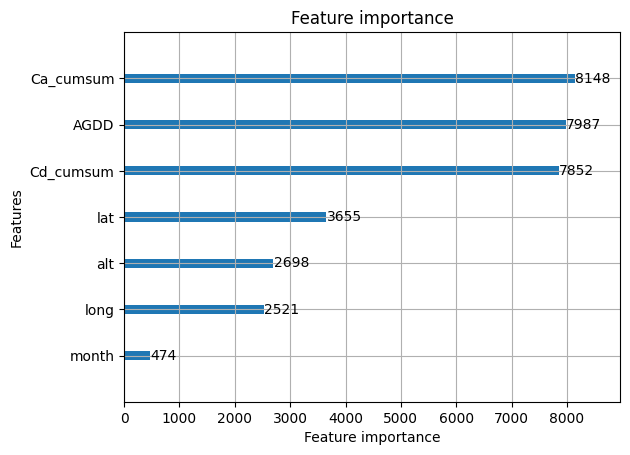

In [75]:
lgb.plot_importance(lgb_kyoto)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

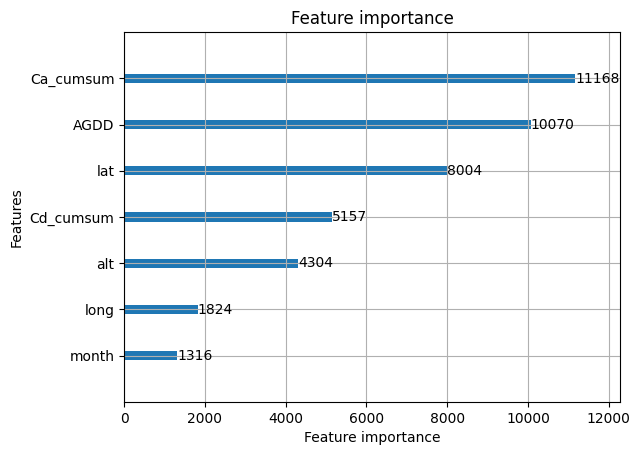

In [76]:
lgb.plot_importance(lgb_liestal)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

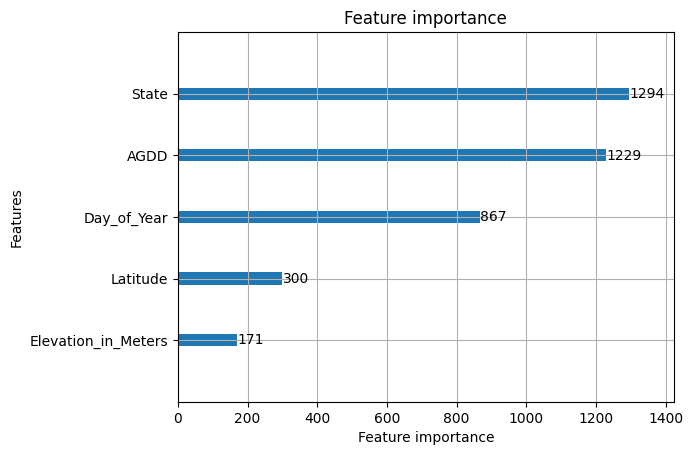

In [77]:
lgb.plot_importance(lgb_ame)